In [2]:
import re
import os
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [11]:
def get_teams(html, team_id_expression):
    teams = []
    for row in BeautifulSoup(html).select('.standings__table div.team-link .dn'):
        
        abbr = row.select('abbr')[0]
        link = row.select('a.AnchorLink')[0].get('href')
        team_id = re.search(team_id_expression, link).group(1)

        teams.append({
            'id': team_id,
            'abbr': abbr.text,
            'title': abbr.get('title')
        })

    return teams

parsing_options = [
    { 'url': 'https://www.espn.com/womens-college-basketball/standings', 'path': '../../data/wnba/wncaa_teams.csv', 'team_id_expression': r'\/(?:id)\/(\w+)\/' },
    { 'url': 'https://www.espn.com/wnba/standings', 'path': '../../data/wnba/wnba_teams.csv', 'team_id_expression': r'\/(?:name)\/(.+)' },
]

for option in parsing_options:
    url = option['url']
    path = option['path']
    team_id_expression = option['team_id_expression']

    if not os.path.exists(path):
        response = requests.get(url)
        assert response.status_code == 200

        df_teams = pd.DataFrame(
            get_teams(response.text, team_id_expression)
        )

        df_teams.to_csv(path, index=False)

In [13]:
def get_games(html):
    games = []
    for tr in BeautifulSoup(html).select('.Table__TR'):
        cols = [ col for col in tr.select('td:not(.ttu)') ]
        if len(cols) != 7:
            continue

        game_id = ''
        links = cols[2].select('.AnchorLink')
        if len(links) != 0:
            game_id = re.search(r'\/gameId\/(\w+)$', links[0].get('href')).group(1)

        games.append({
            'date': re.sub(r'(Sun|Mon|Tue|Wed|Thu|Fri|Sat), ', '', cols[0].text),
            'team_id': team_id,
            'game_id': game_id,
        })

    return games

parsing_options = [
    {
        'template_url':  'https://www.espn.com/womens-college-basketball/team/schedule/_/id/@@ID@@/season/@@YEAR@@',
        'teams_path': '../../data/wnba/wncaa_teams.csv',
        'games_path': '../../data/wnba/wncaa_games.csv',
        'years': ['2021'],
    },
    {
        'template_url':  'https://www.espn.com/wnba/team/schedule/_/name/@@ID@@/season/@@YEAR@@',
        'teams_path': '../../data/wnba/wnba_teams.csv',
        'games_path': '../../data/wnba/wnba_games.csv',
        'years': ['2021'],
    },
]

for option in parsing_options:
    template_url = option['template_url']
    teams_path = option['teams_path']
    games_path = option['games_path']
    
    if not os.path.exists(games_path):
        games = []
        for team_id in pd.read_csv(teams_path).id.tolist():
            for year in option['years']:
                response = requests.get(
                    template_url.replace('@@ID@@', str(team_id)).replace('@@YEAR@@', year)
                )

                team_games = get_games(response.text)
                for game in team_games:
                    game.update({ 'year': year })

                games.extend(team_games)

            time.sleep(4)

        df_games = pd.DataFrame(games)
        df_games.to_csv(games_path, index=False)

In [116]:
def parse_wncaa(bs, game_id):
    def get_lineitem(row, team_name, side):
        columns = row.select('td')
        match = re.search(r'\/id\/(.+)\/(.+)', columns[0].select('a')[0].get('href'))

        response = {
            'id': match.group(1),
            'nid': match.group(2),
            'side': side,
            'team_name': team_name,
            'game_id': game_id,
        }

        for i in range(1, len(columns)):
            column = columns[i]
            key = column['class'][0]
            response[key] = column.text

        return response

    selectors = [
        ('away', '.gamepackage-away-wrap'),
        ('home', '.gamepackage-home-wrap')
    ]

    boxscores = []
    for side, selector in selectors:
        section = bs.select(selector)[0]
        team_name = section.select('.team-name')[0].text
        for row in section.select('.mod-data tbody tr:not(.highlight)'):
            boxscores.append(
                get_lineitem(row, team_name, side)
            )

    return boxscores

def parse_wnba(bs, game_id):
    lineitems = []
    stats_cols = ['MIN', 'FG', '3PT', 'FT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', '+/-', 'PTS']
    for side, section in zip(['away', 'home'], bs.select('.Boxscore__ResponsiveWrapper .Wrapper')):
        team_name = section.select('.BoxscoreItem__TeamName')[0].text

        players = [
            (row.text, row.select('a')[0].get('href') if len(row.select('a')) > 0 else '')
            for row
            in section.select('.Table--fixed-left tbody tr')
        ]

        stats = [
            [ col.text for col in row.select('td') ]
            for row
            in section.select('.Table__ScrollerWrapper tbody tr')
        ]
        
        for player, stats in zip(players, stats):
            player_name = player[0]
            if player_name in ['', 'team', 'starters', 'bench']:
                continue

            link = player[1]
            match = re.search(r'\/id\/(.+)\/(.+)', link)

            response = {
                'side': side,
                'team_name': team_name,
                'player_name': player_name,
                'id': match.group(1),
                'nid': match.group(2),
                'game_id': game_id,
            }

            n = len(stats_cols)
            for i in range(0, n):
                value = stats[i] if len(stats) == n else '-'
                response[stats_cols[i]] = value
                
            lineitems.append(response)

    return lineitems

def get_boxscore(html, type, game_id):
    bs = BeautifulSoup(html, 'html.parser')

    if type == 'wncaa':
        return parse_wncaa(bs, game_id)

    if type == 'wnba':
        return parse_wnba(bs, game_id)

    return []

parsing_options = [
    {
        'type': 'wnba',
        'games_path': '../../data/wnba/wnba_games.csv',
        'boxscores_path': '../../data/wnba/wnba_boxscores.csv',
        'url': 'https://www.espn.com/wnba/boxscore/_/gameId/@@GAME@@',
    },
    ## {
    ##     'type': 'wncaa',
    ##     'games_path': '../../data/wnba/wncaa_games.csv',
    ##     'boxscores_path': '../../data/wnba/wncaa_boxscores.csv',
    ##     'url': 'https://www.espn.com/womens-college-basketball/boxscore/_/gameId/@@GAME@@',
    ## },
]

for option in parsing_options:
    parsing_type = option['type']
    games_path = option['games_path']
    boxscores_path = option['boxscores_path']
    template_url = option['url']

    if not os.path.exists(boxscores_path):
        boxscores = []
        for game_id in pd.read_csv(games_path).game_id.unique():
            response = requests.get(
                template_url.replace('@@GAME@@', str(game_id))
            )

            boxscores.extend(
                get_boxscore(response.text, parsing_type, game_id)
            )

            time.sleep(4)

        df_games = pd.DataFrame(boxscores)
        df_games.to_csv(boxscores_path, index=False)

In [133]:
parsing_options = [
    {
        'type': 'wnba',
        'games_path': '../../data/wnba/wnba_games.csv',
        'shot_chart_path': '../../data/wnba/wnba_shot_chart.csv',
        'url': 'https://www.espn.com/wnba/game/_/gameId/@@GAME@@',
    },
]

for option in parsing_options:
    parsing_type = option['type']
    games_path = option['games_path']
    shot_chart_path = option['shot_chart_path']
    template_url = option['url']

    if not os.path.exists(shot_chart_path):
        shot_chart = []
        for game_id in pd.read_csv(games_path).game_id.unique():
            response = requests.get(
                template_url.replace('@@GAME@@', str(game_id))
            )

            bs = BeautifulSoup(response.text, 'html.parser')

            shots = bs.select('li.ShotChart__court__play')
            for shot in shots:
                description = shot.select('span')[0].text
                style = shot.get('style')

                shot_chart.append({
                    'game_id': game_id,
                    'description': description,
                    'location': re.findall('((?:bottom|left):calc\(.+?\);)', style),
                    'made': re.search(r'(background-color:transparent)', style) is None,
                })

            time.sleep(4)

        df_shot_chart = pd.DataFrame(shot_chart)
        df_shot_chart.to_csv(shot_chart_path, index=False)

In [123]:
df = pd.read_csv('../../data/wnba/wnba_shot_chart.csv')
df.head()

,game_id,description,location,made
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"['bottom:calc(32% - 5px);', 'left:calc(78.72% ...",False
1,401391651,Dana Evans misses driving floating jump shot,"['bottom:calc(42% - 5px);', 'left:calc(87.23% ...",False
2,401391651,Azura Stevens makes 23-foot three point jumper...,"['bottom:calc(6% - 5px);', 'left:calc(91.49% -...",True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"['bottom:calc(26% - 5px);', 'left:calc(88.3% -...",True
4,401391651,Candace Parker makes free throw 1 of 2,"['bottom:calc(429496780% - 5px);', 'left:calc(...",True


In [124]:
def is_3pt(row):
    return len(re.findall(r'three\s+point', row)) > 0

df['is_3pt'] = df.description.map(is_3pt)

def who_shot(row):
    match = re.search(r'^([a-z]+[\s-]+)+(?=makes|misses)', row, flags=re.IGNORECASE)
    if match is None:
        return ''

    return match.group().strip()

df['shot_by'] = df.description.map(who_shot)

In [125]:
def parse(loc):
  locations = list(map(float, re.findall(r'calc\(([\d.]+)%', ' '.join(loc))))
  if len(locations) != 2:
    return [-1, -1]

  return locations

def is_valid(loc):
  return not any(list(map(lambda a: a > 100 or a < 0, loc)))

df.location = df.location.map(eval).map(parse)
df['is_valid'] = df.location.map(is_valid)

df.head()

,game_id,description,location,made,is_3pt,shot_by,is_valid
0,401391651,Courtney Vandersloot misses 18-foot pullup jum...,"[32.0, 78.72]",False,False,Courtney Vandersloot,True
1,401391651,Dana Evans misses driving floating jump shot,"[42.0, 87.23]",False,False,Dana Evans,True
2,401391651,Azura Stevens makes 23-foot three point jumper...,"[6.0, 91.49]",True,True,Azura Stevens,True
3,401391651,Candace Parker makes 14-foot two point shot (A...,"[26.0, 88.3]",True,False,Candace Parker,True
4,401391651,Candace Parker makes free throw 1 of 2,"[429496780.0, 228455803.19]",True,False,Candace Parker,False


In [183]:
player = 'Kelsey Plum' ## 'Sylvia Fowles'

def get_coordinates(df):
  x = df.location.map(lambda a: a[1])
  y = df.location.map(lambda a: a[0])

  return x, y

df_sub = df[df.shot_by == player]
df_sub = df_sub[df_sub.is_valid]

print(len(df_sub))

x_make, y_make = get_coordinates(df_sub[df_sub.made])
x_missed, y_missed = get_coordinates(df_sub[~df_sub.made])

404


In [209]:
x_scale = 5
y_scale = 3

In [210]:
from PIL import Image

img = Image.open('../../data/wnba/ml-bg-court.png').resize((x_scale * 100, y_scale * 100), Image.ANTIALIAS)
img.size

(500, 300)

Kelsey Plum - shot chart


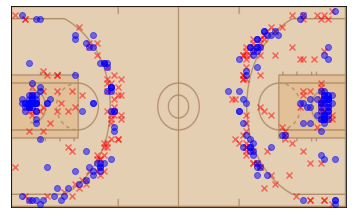

In [211]:
print(f'{player} - shot chart')

fig, ax = plt.subplots()

ax.imshow(img)

plt.xticks([])
plt.yticks([])

plt.scatter(x_missed * x_scale, y_missed * y_scale, marker='x', c='red', alpha=.5)
plt.scatter(x_make * x_scale, y_make * y_scale, marker='o', c='blue', alpha=.5)

plt.show()

In [212]:

## todo... tie back in with shot chart?
#https://www.espn.com/womens-college-basketball/playbyplay/_/gameId/401414472
